# Corona Virus Case Details

> **Authors**
- [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)


**Prerequisites**

- [Regression](regression.ipynb)  
- [Data Visualization: Rules and Guidelines](visualization_rules.ipynb)  
- [Visualizing Corona Virus](covid-trends.ipynb)  


**Outcomes**

- Estimate Corona Virus mortality rates conditional on age.  

## Outline

- [Corona Virus Case Details](#Corona-Virus-Case-Details)  
  - [Introduction](#Introduction)  
  - [Data](#Data)  
  - [Exercises](#Exercises)  

In [1]:
# Uncomment following line to install on colab
#! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

## Introduction

This notebook works with Covid-19 case details. A handful of
countries/places are releasing some details about people with
confirmed cases of Covid-19. Specifically, [Singapore](https://www.wuhanvirus.sg/cases/search), [Hong Kong](https://wars.vote4.hk/en/cases), [South Korea](https://github.com/jihoo-kim/Coronavirus-Dataset/), and [the
Phillipines](https://coronavirus-ph-api.now.sh/cases) provide case
by case information on age, gender, and a few other
variables. Liquiddata, the company that created Dolthub, aggregates
and updates this data every hour.  The combined data is available [on
dolthub](https://www.dolthub.com/repositories/Liquidata/corona-virus).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection, preprocessing
)

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();
colors = qeds.themes.COLOR_CYCLE
import urllib.request
import zipfile

## Data

Getting data off dolthub requires installing dolt. Since this is not
easy to do on a jupyter server, we have installed dolt on another
server. That server downloads data from dolt, and uploads it to
[http://faculty.arts.ubc.ca/pschrimpf/covid_case_details.zip](http://faculty.arts.ubc.ca/pschrimpf/covid_case_details.zip) . This
gets updated every three hours. The dolt commands to get the data are
below. You should not need to run these yourself.

In [3]:
#!dolt clone Liquidata/corona-virus  # Only run once
#!cd corona-virus
#!dolt pull
#!dolt checkout master
#!dolt table export case_details case_details.csv
#!dolt table export places places.csv
#!dolt checkout case_details_virological_dot_org
#!dolt table export case_details case_details_v.csv
#!zip covid_case_details.zip *.csv

We can just download the copy of the data created by the commands above.

In [4]:
import io

url = 'http://faculty.arts.ubc.ca/pschrimpf/covid_case_details.zip'

with zipfile.ZipFile(io.BytesIO(urllib.request.urlopen(url).read())) as zip :
    places = pd.read_csv(zip.open('places.csv'))
    cases = pd.read_csv(zip.open('case_details_v.csv'))
    #cases0 = pd.read_csv(zip.open('case_details.csv'))

cases = pd.merge(cases, places, how="left", on="place_id")
cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49861 entries, 0 to 49860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   source            49861 non-null  object 
 1   case_id           49861 non-null  int64  
 2   case_name         43377 non-null  object 
 3   age               5384 non-null   float64
 4   sex               5373 non-null   object 
 5   nationality       2579 non-null   object 
 6   current_status    3066 non-null   object 
 7   symptomatic_date  1250 non-null   object 
 8   confirmed_date    47258 non-null  object 
 9   recovered_date    418 non-null    object 
 10  place_id          12799 non-null  float64
 11  province_state    3088 non-null   object 
 12  country_region    12799 non-null  object 
 13  latitude          12799 non-null  float64
 14  longitude         12799 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 6.1+ MB


### Mortality by Age

We can use this data to calculate mortality conditional on age.

In [5]:
cases["dead"] = np.nan
cases["dead"] = cases.current_status.str.contains("Deceased|deceased|dead")
cases.dead.value_counts()

False    2937
True      129
Name: dead, dtype: int64

Below we will divide ages into a bunch of bins, compute the average
mortality in each bin, and plot it. The shaded area is a 95%
point-wise confidence interval.

(0.0, 0.4)

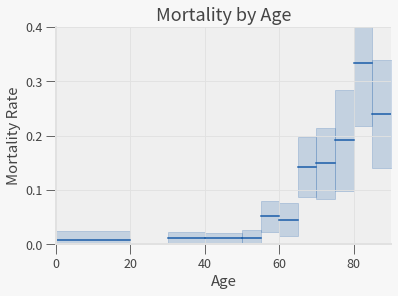

In [6]:
agebins = [0, 20, 30, 40, 50, 55, 60, 65, 70, 75, 80, 85, 110]
fig, ax = plt.subplots()
for i in range(len(agebins)-1):
    mrate = np.mean(cases.query(f"age>={agebins[i]} and age<{agebins[i+1]}").dead)
    n = cases.query(f"age>={agebins[i]} and age<{agebins[i+1]}").dead.count()
    se = np.sqrt(mrate*(1-mrate)/n)
    ax.plot(agebins[i:(i+2)], [mrate, mrate], color=colors[0])
    ax.fill_between(agebins[i:(i+2)], [mrate-1.96*se, mrate-1.96*se],
                    [mrate+1.96*se, mrate+1.96*se], alpha=0.2, color=colors[0])

ax.set_title("Mortality by Age")
ax.set_xlabel("Age")
ax.set_ylabel("Mortality Rate")
ax.set_xlim((0,90))
ax.set_ylim((0,0.4))

We can accomplish something similar using seaborn. Here, in addition
to plotting binned averages, we show the fit from a regression of
death on a 5th degree polynomial of age.

Text(0, 0.5, 'Mortality Rate')

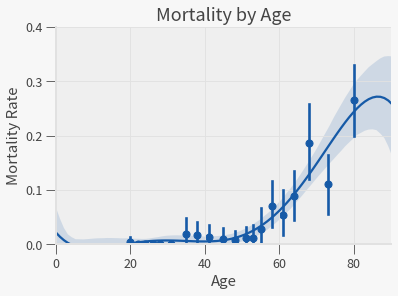

In [7]:
import seaborn as sns
df = cases[['age','dead']].copy()
df.loc[:,'dead'] = df['dead'].astype(float)
ax=sns.regplot(x='age',y='dead', data=df,x_bins=20,  logistic=False, order=5)
ax.set_xlim((0,90))
ax.set_ylim((0,0.4))
ax.set_title("Mortality by Age")
ax.set_xlabel("Age")
ax.set_ylabel("Mortality Rate")


<a id='exercise-0'></a>
> See exercise 1 in the [*exercise list*](#exerciselist-0)

## Exercises


<a id='exerciselist-0'></a>
**Exercise 1**

Create tables and/or figures showing mortality rates by gender.

In [8]:
# your code here

([*back to text*](#exercise-0))